In [1]:
import pyhf
pyhf.set_backend('jax')
import jax
import jaxlib
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

## PyHEP 2020 -- Tutorial on Automatic Differentiation


### Introduction

Welcome to this tutorial on automatic differentiation. Automatic Differentiation is a method to compute exact derivatives of functions implements as **programs**. It's a widely applicable method and famously is used in
many Machine learning optimization problems. E.g. neural networks, which are parametrized by weights $\text{NN}(\text{weights})$ are trained by (stocastic) **gradient** descent to find the minimum of the loss function $L$ where 


$$\text{weights}_\text{opt} = \text{argmin}_\text{weights} L(\text{weights}) \hspace{1cm} \nabla L(\text{weights}) = 0$$


This means that efficient algorithms to compute derivatives are crucial.

Aside from ML, many other use-cases require gradients: standard statistical analysis in HEP (fitting, hypothesis testing, ...) requires gradients. Uncertainty propagation (e.g. track parameters) uses gradients, etc..



### Other approaches to differentiation

Before diving into automatic differentiation, let's review how my might otherwise compute derivatives



#### Finite Differences


A common appraoch to approximate gradients of a black-box function is to evaluate it
at close-by points $x$ and $x+Δx$ and 

$\frac{\partial f}{\partial x} \approx \frac{f(x) - f(x+\Delta x}{\Delta x}$ if $\Delta x$ is sufficiently small


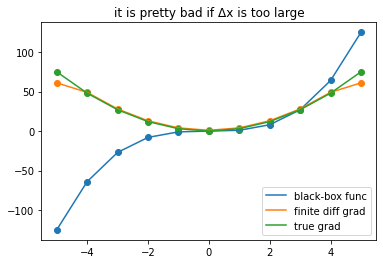

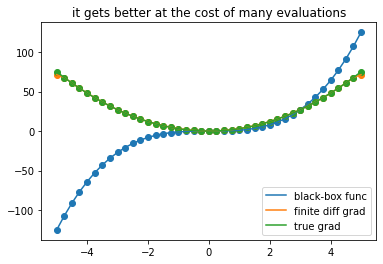

In [2]:
def black_box_func(x):
    return x**3

def true_gradient_func(x):
    return 3*x**2


def plot_gradients(nsteps,title):
    xi = np.linspace(-5,5,nsteps)
    yi = black_box_func(xi)

    approx_gradient = np.gradient(yi,xi)
    true_gradient   = true_gradient_func(xi)

    plt.plot(xi,yi, label = 'black-box func')
    plt.scatter(xi,yi)

    plt.plot(xi,approx_gradient, label = 'finite diff grad')
    plt.scatter(xi,approx_gradient)

    plt.plot(xi,true_gradient, label = 'true grad')
    plt.scatter(xi,true_gradient)

    plt.legend()
    plt.title(title)
    plt.show()
    
    
plot_gradients(11, title = 'it is pretty bad if Δx is too large')
plot_gradients(41, title = 'it gets better at the cost of many evaluations') 

<p style="width: 500px">
while only approximate, finite differences is *simple*. I don't need to know 
anything about the function beyond having the ability 
to *evaluate* it
</p>
<p style="width: 500px">
This way I can compute gradients of functions encoded as a computer
program, and it works in any programming language
</p>

<p style="width: 500px">
For multivariate (possibly vector-valued) functions $\vec{f}(\vec{x}) = f_i(x_1,x_2,\dots,x_n)$ one needs to compute a finite difference
gradient for each partial derivative $\frac{\partial f}{\partial x}$ in order to get the
full jacobian / total derivative $df_i = J_{ik} dx_k\; J_{ik} = \frac{\partial f_i}{\partial x_k}$
    
In high dimensions, the number of required evaluations explodes!
<p>


**Finite Differences**:

* Pro: easy to to, works in any language, no "framework needed"
* Con: inaccurate unless one does a lot of evaluations
* Con does not scale to large dimensions

### Symbolic Differentiation in a CAS

Computer Algebra Systems (CAS), such as Mathematica (or sympy)
can manipulate functional *expressions* and know about differentiation rules (and many other things)

If the function / the prograrm which we want to derive is available as such an expression the 
symbolic differentiation can produce **exact gradients**

In [3]:
import sympy

def function(x):
    return x**3

def true_deriv(x):
    return 3*x**2

symbolic_x = sympy.symbols('x')
symbolic_func = function(symbolic_x)
symbolic_func

x**3

Using `lambdify` we can turn it into a normal python function we can evaluate

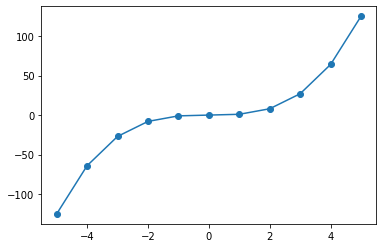

In [4]:
xi = np.linspace(-5,5,11)
yi = sympy.lambdify(symbolic_x,symbolic_func)(xi)
plt.plot(xi,yi)
plt.scatter(xi,yi)

`symbolic_func` is now an experssion which we can differentiate *symbolically*

In [5]:
symbolic_deriv = symbolic_func.diff(symbolic_x)
symbolic_deriv

3*x**2

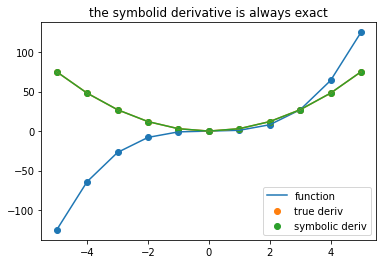

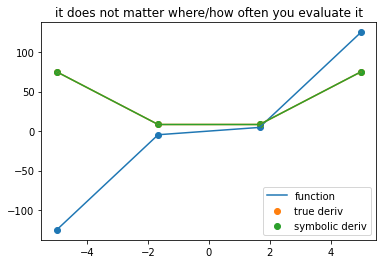

In [6]:
def plot_symbolic(nsteps,title):
    xi = np.linspace(-5,5,nsteps)
    yi = sympy.lambdify(symbolic_x,symbolic_func)(xi)
    plt.scatter(xi,yi)
    plt.plot(xi,yi, label = 'function')



    yi = true_deriv(xi)
    plt.plot(xi,yi)
    plt.scatter(xi,yi, label = 'true deriv')

    yi = sympy.lambdify(symbolic_x,symbolic_deriv)(xi)
    plt.plot(xi,yi)
    plt.scatter(xi,yi, label = 'symbolic deriv')

    plt.legend()
    plt.title(title)
    plt.show()
    
    
plot_symbolic(11,title = 'the symbolid derivative is always exact')
plot_symbolic(4, title = 'it does not matter where/how often you evaluate it')    

#### Chain Rule in CAS

We can even handle function compositions

In [7]:
def f1(x):
    #standard operations are overloaded
    return x**2

def f2(x):
    #note here we use a special cos function from sympy
    #instead of e.g. np.cos or math.cos
    return sympy.cos(x) 
    

composition = f2(f1(symbolic_x))

composition

cos(x**2)

In [8]:
composition.diff(symbolic_x)

-2*x*sin(x**2)

Since `sympy` knows about the chain rule it can differentiate accordingly

#### Problems with Symbolic Differentiation

This looks great! We get exact derivatives. However,
there are drawbacks

1. Need to implement it in CAS

Most functions we are interested in are not implemented 
e.g. Mathematica. Rather we have loads of C, C++, Python
code that we are interested in. 

But ok, `sympy` alleviates this to some degree. The functions
`f1` and `f2` are fairly generic since they use operator
overloading. So a symbolic program and a "normal" program
could only differ by a few import statements



```python
from sympy import cos

def f1(x):
    return x**2

def f2(x):
    return cos(x) 
```

versus:

```python
from math import cos

def f1(x):
    return x**2

def f2(x):
    return cos(x) 
```


Note the code is almost exactly the same

But not all our functions are so simple!


**Expression swell**

Let's look at a quadratic map which is applied a few times

In [9]:
def quadmap(x):
    return x**2 + 3*x + 4

def func(x):
    for i in range(6):
        x = quadmap(x)
    return x

quad_6_times = func(symbolic_x)
quad_6_times

243*x**2 + 729*x + 81*(x**2 + 3*x + 4)**2 + 27*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 9*(9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52)**2 + 3*(27*x**2 + 81*x + 9*(x**2 + 3*x + 4)**2 + 3*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + (9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52)**2 + 160)**2 + (81*x**2 + 243*x + 27*(x**2 + 3*x + 4)**2 + 9*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 3*(9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52)**2 + (27*x**2 + 81*x + 9*(x**2 + 3*x + 4)**2 + 3*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + (9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52)**2 + 160)**2 + 484)**2 + 1456

This looks pretty intimidating. What happened? 
Symbolic programs run through the prgram and 
accumulate the full program into a single expression

If we would just blindly differentiate this it would look like this

In [10]:
quad_6_times.diff(symbolic_x)

486*x + 81*(4*x + 6)*(x**2 + 3*x + 4) + 27*(12*x + 2*(4*x + 6)*(x**2 + 3*x + 4) + 18)*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16) + 9*(36*x + 6*(4*x + 6)*(x**2 + 3*x + 4) + 2*(12*x + 2*(4*x + 6)*(x**2 + 3*x + 4) + 18)*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16) + 54)*(9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52) + 3*(108*x + 18*(4*x + 6)*(x**2 + 3*x + 4) + 6*(12*x + 2*(4*x + 6)*(x**2 + 3*x + 4) + 18)*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16) + 2*(36*x + 6*(4*x + 6)*(x**2 + 3*x + 4) + 2*(12*x + 2*(4*x + 6)*(x**2 + 3*x + 4) + 18)*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16) + 54)*(9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52) + 162)*(27*x**2 + 81*x + 9*(x**2 + 3*x + 4)**2 + 3*(3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + (9*x**2 + 27*x + 3*(x**2 + 3*x + 4)**2 + (3*x**2 + 9*x + (x**2 + 3*x + 4)**2 + 16)**2 + 52)**2 + 160) + (324*x + 54*(4*x + 6)*(x**2 + 3*x + 4) + 18*(12*x + 2*(4*x + 6)*(x**2 + 3*x + 4) +

This looks even worse!

Also note that that if we just blindly substitute x for some value
e.g. x=2, we would be computing a lot of the same terms
manyt times. E.g. in the above expression $x^2+3x+4$ appears in a 
lot of places due to the "structure' of the original progrm

If you knew the structure of the program you likely could precompute
some of these repeating terms. However once it got all expanded all
this knowledge about the structure is gone!

Modern CAS can recover some of this by finding "common subexpressions" (CSE)

In [11]:
sympy.cse(quad_6_times)

([(x0, x**2),
  (x1, (3*x + x0 + 4)**2),
  (x2, (9*x + 3*x0 + x1 + 16)**2),
  (x3, (27*x + 9*x0 + 3*x1 + x2 + 52)**2),
  (x4, (81*x + 27*x0 + 9*x1 + 3*x2 + x3 + 160)**2)],
 [729*x + 243*x0 + 81*x1 + 27*x2 + 9*x3 + 3*x4 + (243*x + 81*x0 + 27*x1 + 9*x2 + 3*x3 + x4 + 484)**2 + 1456])

But it's not as automatic and may note find all relevant subexpressions. In any case it's trying hard to recover some
of the structure that is already implicitly present in the prograam we want to differentiate

**Control Flow**

In addition to looping constucts like above, a lot of the functions we are interested in have 
control flow structures like if/else statements, while loops, etc..


If we try to create a symbolic expression with conditionals we fail badly


In [12]:
def func(x):
    if x > 2:
        return x**2
    else:
        return x**3
    
symbolic_result = func(symbolic_x)

TypeError: cannot determine truth value of Relational

That's too bad because this is a perfectly respectable functino *almost everywhere*

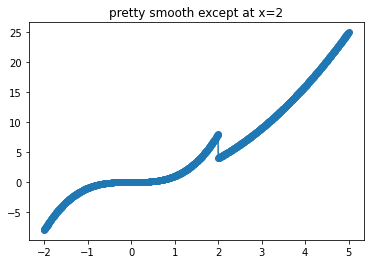

In [13]:
xi = np.linspace(-2,5,1001)
yi = np.asarray([func(xx) for xx in xi])

plt.plot(xi,yi)
plt.scatter(xi,yi)
plt.title("pretty smooth except at x=2")
plt.show()

If we could afford finite diffences it would compute gradients *just fine*.

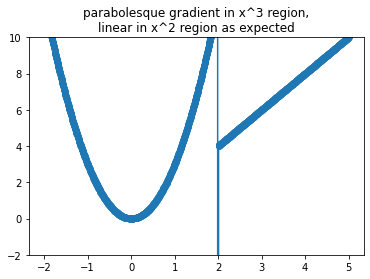

In [14]:
g = np.gradient(yi,xi)
plt.plot(xi,g)
plt.scatter(xi,g)
plt.ylim(-2,10)
plt.title('''\
parabolesque gradient in x^3 region,
linear in x^2 region as expected''');

In short: symbolic differentiation is not our saving grace.

* Pro: Gradients are exact, if you can compute them
* Con: Need to implement in CAS. Full-featured Cas not easily available in all languages
* Con: lead to expression swell by losing any structure of the program (needs to be recovered separately0
* Con: Cannot handle common control-flow structures like loops and conditionals easily

## What we need

To recap: 

Finite differences is
* easy to implement in any language
* handles arbitrary (halting) programs but
* is inaccurate unless we're ready to pay a large computational overhead

Symbolic differentiation is:
* exact to machine precision
* can lead to exccessive / inefficient computation if not careful
* cannot handle complex programs with control flow structures


<h4> So what we need is a third approach! </h4>

One, that is 
* exact
* efficient
* can handle arbitrayr programs
* that is easy to implement in many languages


This third approach is 'Automatic' differentiation.

## Short Interlude on Linear Transformations

Before we start, let's first look at *linear transformations** from ℝᵐ → ℝⁿ:
$$y(x) = Ax$$

With a given basis, this is representable as a (rectangular0 matrix: 
$$y_i(x) = A_{ij}x_j$$


For a given linear problem, there are few ways we can run this computation


1. **full matrix computation**

   i.e. we store the full (dense) $nm$ elements of the rectangular matrix and 
   compute an explicit matrix multiplication.
   
   The computation can be fully generic for any matrix
   
```python
    def result(matrix, vector):
        return np.matmul(matrix,vector)
```
<br/>

2. **sparse matrix computation**

   If many $A_ij=0$, it might be wasteful to expend memory on them. We can just 
   create a sparse matrix, by
   
   * storing only the non-zerro elements 
   * storing a look-up table, where those elements are in the matrix
   
   The computation can be kept general

```python
    def result(sparse_matrix, vector):
        return sparse_matmul(sparse_matrix,vector)
```

<br/>
   
3. **matrix-free computation**

    In many cases a linear program is not explicitly given by a Matrix, but it's
    given as *code* / a "black-box" function. As long as the computation in the body of 
    keeps to (hard-coded) linear transformation the program is linear. The matrix elements
    are no longer explicitly enumerated and stored in a data structure
    but implicitly defined in the source code.
    
    This is not anymore a generic computation, but each linear transformation is its own
    program. At the same time this is also the most memory efficient  representation. No
    lookup table is needed since all constants are hard-coded.
    
    
```python
    def linear_program(vector):
        z1,z2 = 0,0
        z1 += A_11*x1
        z2 += A_12*x2
        z2 += A_22*x2
        return [z1,z2]
```






### Recovering Matrix Elements from matrix-free computations


#### Matrix-vector products

In the matrix-free setting, the program does not give access to the matrix elements,
but only computes "matrix-vector" products (MVP)

We can use basis vectors to recover the matrix **one column at a time**

<img src="./assets/mvp.png" alt="A Matrix Vector Product" width="600"/>



In [15]:
def matrix_vector_product(x):
    x1,x2,x3 = x
    z1,z2 = 0,0
    z1 += 2*x1  #MVP statement 1
    z2 += 1*x2  #MVP statement 2
    z2 += 3*x3  #MVP statement 3
    return np.asarray([z1,z2])

M = np.concatenate([
    matrix_vector_product(np.asarray([1,0,0])).reshape(-1,1),
    matrix_vector_product(np.asarray([0,1,0])).reshape(-1,1),
    matrix_vector_product(np.asarray([0,0,1])).reshape(-1,1),
],axis=1)
print(f'M derived from matrix-vector products:\n{M}')

M derived from matrix-vector products:
[[2 0 0]
 [0 1 3]]


#### Vector Matrix product (VMP)

The same matrix induces a "dual" linear map: ℝⁿ → ℝᵐ 
$$ x_k = y_i A_{ik}$$

i.e. instead of a Matrix-vector product it's now a *vector-Matrix* product (VMP)

If one has access to a "vector-Matrix" program corresponding to a matrix $A$ one
can again -- as in the MVP-case -- recover the matrix elements, by feeding in basis vectors.

This time the matrix is built **one row at a time**


<img src="./assets/vmp.png" alt="A Matrix Vector Product" width="600"/>

In [16]:
def vector_matrix_product(z):
    x1,x2,x3 = 0,0,0
    z1,z2 = z

    x3 += z2*3 #VMP version of statement 3
    x2 += z2*1 #VMP version of statement 2
    x1 += z1*2 #VMP version of statement 1

    return np.asarray([x1,x2,x3])


M = np.concatenate([
    vector_matrix_product(np.asarray([1,0])).reshape(1,-1),
    vector_matrix_product(np.asarray([0,1])).reshape(1,-1),
],axis=0)
print(f'M derived from vector-matix products:\n{M}')

M derived from vector-matix products:
[[2 0 0]
 [0 1 3]]


#### Short Recap:

For a given linear transformation, characterized by a matrix $A_{ij}$ we have a forward (matrix-vector) and backward (vector-matrix) map $$y_i = A_{ij}x_k$$ $$x_j = y_i A_{ij}$$

and we can use either to recover the full matrix $A_{ij}$

## Wide versus Tall Transformation

If you look at the code above, you'll notice that the number of calls necessary to the MVP or VMP program
is related to the dimensions of matrix itself.

For a $n\times m$ matrix (for a map: ℝᵐ → ℝⁿ), you need as $m$ calls to the "Matrix-vector" program to 
built the full matrix one-column-at-a-time. Likewise you need $n$ calls to the "vector-Matrix" program
to build the matrix one-row-at-a-time.

This becomes relevant for very asymmetric maps: e.g. scalar maps from very high-dimensional spaces
$\mathbb{R}^{10000} \to \mathbb{R}$ the "vector-Matrix" appraoch is *vastly* more efficient than the
"Matrix-vector one. There's only one row, so only one call too the VMP program is needed to construct the full matrix!

Similarly, functions mapping few variables into very high dimensional spaces $\mathbb{R} \to \mathbb{R}^{10000}$
it's the opposite: the "Matrix-vector" approach is much better suited than the "vector-Matrix" one (this time it's a single column!).


## Function Compositions

Of course copositions $(f\circ g)(x) = f(g(x))$ of linear maps are also linear, so the above applies.

<img src="./assets/composition.png" alt="A Matrix Vector Product" width="400"/>

Depending on whether the "Matrix-vector" or "vector-Matrix" appraoch is used, the data is propagated **forwards** or **backwards**.

<span><img style="display: inline;margin-left:100px;" src="./assets/forward.png" alt="A Matrix Vector Product" width="400"/></span>
<span><img style="display: inline"  src="./assets/backward.png" alt="A Matrix Vector Product" width="400"/></span>

### From Matrices to Graphs

The "vector-Matrix" or "Matrix-vector" picture can be generalized to arrbitrary directed acyclic graphs.

* In the "Matrix-vector" picture the node value is the edge-weighted sum of the "upstream nodes".
* In the "vector-Matrix" picture the node value is the edge-weighted sum of its "downstream nodes".

(one could in principle always recove a rectangular/matrix-like version of a DAG  by inserting trivial nodes)


<span><img style="display: inline;margin-left:100px;"  src="./assets/graphs.png" alt="A Matrix Vector Product" width="500"/></span>
<span><img style="display: inline"  src="./assets/dag.png" alt="A Matrix Vector Product" width="300"/></span>


In [17]:
def graph_like(x):
    x1,x2,x3 = x
    y1 = 2*x1+x2
    z1,z2 = y1+2*x3,x3-y1 #note that we reach "over" the "ys" and diectly touch x_n
    return np.asarray([z1,z2])

def matrix_like(x):
    x1,x2,x3 = x
    y1 = 2*x1+x2
    y2 = x3 #can just introduce a dummy variable to make it matrix-like
    z1,z2 = y1+2*x3,y2-y1
    return np.asarray([z1,z2])


In [18]:
M = np.concatenate([
    matrix_like(np.asarray([1,0,0])).reshape(-1,1),
    matrix_like(np.asarray([0,1,0])).reshape(-1,1),
    matrix_like(np.asarray([0,0,1])).reshape(-1,1),
],axis=1)
print(f'M derived from matrix like computation:\n{M}')


M = np.concatenate([
    graph_like(np.asarray([1,0,0])).reshape(-1,1),
    graph_like(np.asarray([0,1,0])).reshape(-1,1),
    graph_like(np.asarray([0,0,1])).reshape(-1,1),
],axis=1)
print(f'M derived from graph-like products:\n{M}')

M derived from matrix like computation:
[[ 2  1  2]
 [-2 -1  1]]
M derived from graph-like products:
[[ 2  1  2]
 [-2 -1  1]]


# Derivatives


Why are we talking about linear transformations? After all lot of the code we write is non-linear! However, derivatives are always linear.

And derivatives (the jacobian) of a composition $f\circ g$ is the composition of linear derivatives (the jacobians
of each map) i.e. the full jacobian Matrix is the  result of multipying all Jacobians of the composition.
$$J = J_0 J_1 J_2 J_3 \dots J_n $$

(This is just the chain rule)
$$z = f(y) = f(g(x))\hspace{1cm} \frac{\partial f_i}{\partial x_j} = \frac{\partial f_i}{\partial z_j}\frac{\partial z_j}{\partial x_k}$$ 


I.e. finding derivatives, means characterizing the jacobian matrix. From the above discussion, we can use the "Jacobian-vector product" (JVP, builds Jacobians column-wise) or "vector-Jacobian product" (builds Jacobians row-wise) approach.

In the language of automatic differentiation 

* Jacobian-vector products (JVP) = forward mode (forward propagation)

$$ Jv_n =  J_0 J_1 J_3 \dots J_n v_n = J_0 J_1 J_2 J_3 v_3 = J_0 J_1 J_2 v_2 = J_0 J_1 v_1 = J_0 v_0 = \text{col}$$

* vector-Jacobian products (VJP) = reverse mode (reverse propagation)

$$ v_0 J = v_0 J_0 J_1 J_3 \dots J_n = v_1 J_1 J_2 J_3 \dots J_n = v_2 J_2 J_3 \dots J_n = v_3 J_3 \dots J_n = \dots = v_n J_n = \text{row}$$


### Example

Let's work this out on a very simple problem


<img src="./assets/intro_autodiff.png" alt="A Matrix Vector Product" width="700"/>

In the forward pass we use "Matrix-vector" products and need to do two evaluation

<img src="./assets/intro_fwd.png" alt="A Matrix Vector Product" width="700"/>

In the backward pass we use "vector-Matrix" products and need to do only a single evaluation

<img src="./assets/intro_bwd.png" alt="A Matrix Vector Product" width="700"/>

Both approaches give the same result. Since this is a map from $\mathbb{R}^2 \to \mathbb{R}^1$ the backward pass is more efficient than the forward pass


Let's look at a real-life example

$$z(x_1,x_2) = y + x_2 = x_1x_2 + x_2$$

This is easy python code

In [19]:
def mul_func(x1,x2):
    return x1*x2

def sum_func(x1,x2):
    return x1+x2

def function(x):
    x1,x2 = x
    y = mul_func(x1,x2)
    z = sum_func(y,x2)
    return z

print(function([2,4]))

12


In the forward pass, an autodiff system needs to create a JVP implementation for each elementary operation 

In [20]:
def mul_jvp(x1,dx1,x2,dx2):
    y  = mul_func(x1,x2)
    dy = x1*dx2 + x2*dx1
    return y, dy

def sum_jvp(x1,dx1,x2,dx2):
    return sum_func(x1,x2), dx1 + dx2

def function_jvp(x,dx):
    x1,x2 = x
    dx1,dx2 = dx
    y, dy = mul_jvp(x1,dx1,x2,dx2)
    z, dz = sum_jvp(y,dy, x2, dx2)
    return z,dz

Since in the forward pass we build "column-at a time" and our final jacobian is has shape (1x2), i.e. two columns we need two forward passes to get the full Jacobian. Not that for eacch forward pass we also get the fully computed functino value delivered on top!


Also note that the "JVP" version of the functino has the same *structure* as the original function. For each call in the original program there is an equivalent call in the JVP program. However the JVP call does always two things at once

1. compute the nominal result
2. compute the differentials

So it has roughly 2x the run-time as the original program (depending on the complexity of the derivatives). Said another way: computing the one-pass in the derivative has the same computational complexity as the function itself.

In [21]:
print(function_jvp([2,4],[1,0]))
print(function_jvp([2,4],[0,1]))

(12, 4)
(12, 3)


For the backward pass we build "row-at-a-time'. For each elementary operation we need to build a VJP implementation

In [22]:
def mul_vjp(x1,x2,dx1,dx2,dout):
    dx2 += dout * x1
    dx1 += dout * x2
    return dx1,dx2

def sum_vjp(x1,x2,dx1,dx2,dout):
    dx1 += dout * 1
    dx2 += dout * 1
    return dx1,dx2

def function_vjp(x,dz):
    
    #run forward
    x1,x2 = x
    y = mul_func(x1,x2)
    z = sum_func(y,x2)

    #zero gradients
    dy  = 0    
    dx1 = 0
    dx2 = 0
    
    #run backward
    dy,dx2  = sum_vjp(y,x1, dy, dx2, dz)
    dx1,dx2 = mul_vjp(x1,x2, dx1, dx2, dy)
    return z,[dx1,dx2]

Here, we see the power of backward propagation (or the reverse mode)  we get all gradients of the single row ine oone go. Since this Jacobian only has one row, we're done! And we get the function value delivered on top of the gradients as well!

In [23]:
print(function_vjp([2,4],1.0))

(12, [4.0, 3.0])


Again, let's look at the "VJP" code. The forward pass is *exactly* the same as the original function. This just records the final result and all intermediate values, which we will need for the backward pass.

Moving on to the backward pass, we see again, as in JVP, it has the same *structure* as the forward pass. For each call to a subroutine there is an equivalent call in the backward pass to compute the VJP. 


As in the JVP case, the computational complexity of one backward pass is roughly the same as the forward pass. Now unlike the JVP-case we only needed a single pass for **all the gradients** of this scalar function. So obtaining the **full gradient** of a function is only as expensive as the function itself.

## Recap:

Above we have built a *manual* autodiff system. Let's recap what we needed to do

* define a set of operations we want to be differentiable
* define sub-routines for nominal operations, JVP and VJP



Once given a program, we had to do the following

**In the forward mode**:

* just replace the nominal function with the JVP one
* for each variable in the program allocate a "differential" variable and pass it
  into the JVP whereever we also pass the nominal variable
  
  
**In the backward mode**:

* Run the program forward, keep track of all values
* keep track of the order of operations on a "record" of sorts
* allocate "differential" variables for all values and initialize to zero
* use the record to replay the order of operations backwards, passing along the 
  appropriate differential values, and updating the relevant ones with the result
  of the VJP


All of this is pretty mechanistic and hence "automatable". And given that it's a very narrow
domain of only implementing JVP/JVP operations this is easy to do in any language.

That's why it's **automatic differentiation**
  
  
What we gain from this is that we get

* exact derivatives (to machine precision) for arbitrary composed of the operations we define
* complexity of a derivative-pass through the program is of same order of complexity as the original program
* often only a single pass is necessary (e.g. scalar multi-variate functions)
* unlike symbolic differrentiation, the structure of the program is preserved and allows naturally to avoid
  repetitive calculations of the same values
* (we will see that) arbitrary control flows are handles naturally
* it's something that is easy for a comoputer do and for a progarmmer to imlpement



Some notes on pros and cons:

**In the forward mode**:

the signature of each opeartion basically extends 
  ```c++
  float f(float x,float y,float z)
  ```
  to
  ```c++
  pair<float> f(float x,float dx,float y,float float dy, float z,float dz)
  ```
  * if you use composite types ("dual numbers") that hold both x,dx you can basically 
    keep the signature unchanged
    ```c++
    f(dual x, dual x, dual z)
    ```
  * together with operator overloading on these dual types e.g. `dual * dual` you can 
    essentially keep the source code unchanged
    ```c++
    float f(float x, float y): return x*y
    ``` 
    ->
    ```c++
    dual f(dual x,dual y): return x*y
    ```
    
* That means it's very easy implement. And memory efficient, no superfluous values are kept when they run out of scope.
* But forward more better for vector-value functions of few parameters


**In the reverse mode**:

* very efficient, but we need to keep track of order (need a "tape" of sorts)
* since we need to access all intermediate varriables, we can run into memory bounds
* the procedurer is a bit more complex than fwd: 1) run fwd, 2) zero grads 3) run bwd


## I don't want to implement an autodiff system.. Aren't there libraries for this??

Yes there are! And a lot of them in many languages. On the othe rhand, try finding CAS systems in each of those 

<img src="./assets/autodiff_systems.png" alt="A Matrix Vector Product" width="700"/>

This is PyHEP, so let's focus on Python. Here, basically what you think of as "Machine Learning frameworks" are at the core autodiff libraries

* Tensorflow
* PyTorch
* JAX

Let's focus on jax

In [24]:
import jax
import jax.numpy as jnp

In [25]:
def f(x):
    return x**2

`jax.numpy` is almost a drop-in rerplacement for `numpy`. I do `import jax.numpy as jnp` but if you're daring you could do `import jax.numpy as np`

In [26]:
x = jnp.array([1,2,3])
y = jnp.array([2,3,4])

/Users/lukasheinrich/Code/pyhfdev/dev/pyhfdevenv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [27]:
print(x+y)
print(x*y)
print(jnp.log(x))
print(jnp.exp(y))

[3 5 7]
[ 2  6 12]
[0.         0.69314718 1.09861229]
[ 7.3890561  20.08553692 54.59815003]


In [28]:
def f(x):
    return x**3

In [29]:
print(f(4.0))
print(jax.grad(f)(4.0)) #boom!
print(jax.grad(jax.grad(f))(4.0)) #boom!
print(jax.grad(jax.grad(jax.grad(f)))(4.0)) #boom!
print(jax.grad(jax.grad(jax.grad(jax.grad(f))))(4.0)) #boom!

64.0
48.0
24.0
6.0
0.0


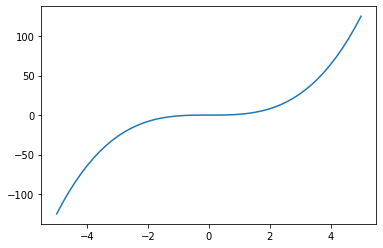

In [30]:
xi = jnp.linspace(-5,5)
yi = f(xi)

plt.plot(xi,yi)

In [31]:
jax.grad(f)(xi)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (50,).

Whoops, jax.grad defaults to reverse mode with a single backward pass, but through broadcasting we get a `vector -> vector` map. We can use some jax magic to "unbroadcast" the function, take the gradient and re-broadcast it

In [32]:
jax.vmap(jax.grad(f))(xi)

DeviceArray([7.50000000e+01, 6.90024990e+01, 6.32548938e+01,
             5.77571845e+01, 5.25093711e+01, 4.75114536e+01,
             4.27634319e+01, 3.82653061e+01, 3.40170762e+01,
             3.00187422e+01, 2.62703040e+01, 2.27717618e+01,
             1.95231154e+01, 1.65243648e+01, 1.37755102e+01,
             1.12765514e+01, 9.02748855e+00, 7.02832153e+00,
             5.27905040e+00, 3.77967514e+00, 2.53019575e+00,
             1.53061224e+00, 7.80924615e-01, 2.81132861e-01,
             3.12369846e-02, 3.12369846e-02, 2.81132861e-01,
             7.80924615e-01, 1.53061224e+00, 2.53019575e+00,
             3.77967514e+00, 5.27905040e+00, 7.02832153e+00,
             9.02748855e+00, 1.12765514e+01, 1.37755102e+01,
             1.65243648e+01, 1.95231154e+01, 2.27717618e+01,
             2.62703040e+01, 3.00187422e+01, 3.40170762e+01,
             3.82653061e+01, 4.27634319e+01, 4.75114536e+01,
             5.25093711e+01, 5.77571845e+01, 6.32548938e+01,
             6.90024990e

that looks better!

`jax.grad(f)` just returns another function. Of course we can just 
take the gradient of that as well. And so on...

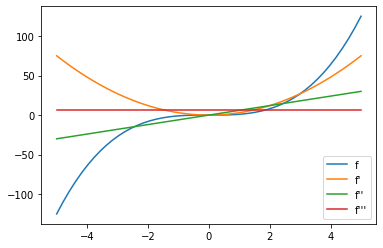

In [33]:
g1i = jax.vmap(jax.grad(f))(xi)
g2i = jax.vmap(jax.grad(jax.grad(f)))(xi)
g3i = jax.vmap(jax.grad(jax.grad(jax.grad(f))))(xi)
plt.plot(xi,yi,  label = "f")
plt.plot(xi,g1i, label = "f'")
plt.plot(xi,g2i, label = "f''")
plt.plot(xi,g3i, label = "f'''")
plt.legend()

# Control Flow

Back when discussing symbolic differentiation we hit a snag when adding 
control flow through to our prorgam. In Jax this just passes through
transparently. 


Let's compare this to finite differences. So far the only system
we had to compute derivatives of control-flow-ful programs

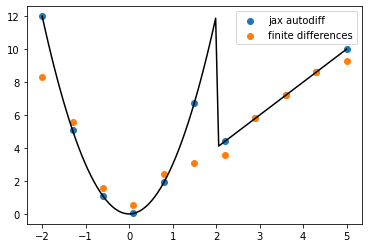

In [34]:
def control_flow_func(x):
    if x > 2:
        return x**2
    else:
        return x**3
    

first_gradient_of_cflow = jax.grad(control_flow_func)
    
xi = jnp.linspace(-2,5,101)
yi = np.asarray([first_gradient_of_cflow(xx) for xx in xi])
plt.plot(xi,yi,c = 'k')

xi = jnp.linspace(-2,5,11)
yi = np.asarray([first_gradient_of_cflow(xx) for xx in xi])
plt.scatter(xi,yi, label = 'jax autodiff')



xi = jnp.linspace(-2,5,11)
yi = np.asarray([control_flow_func(xx) for xx in xi])
plt.scatter(xi,np.gradient(yi,xi), label = 'finite differences')

plt.legend()

We can start to see the benefits autodiff. Among other things, finite differnces becomes
quite sensitive to exactly where the evaluation points are (e.g. wrt  to the discontinuity)


As we compute higher derivatives, this error compounds badly for finite differences. But for
autodiff, it's smooth sailing!

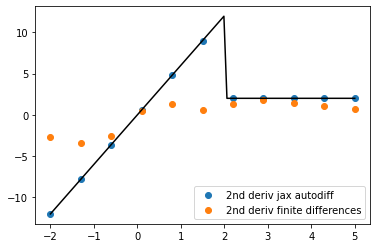

In [35]:
second_gradient_of_cflow = jax.grad(first_gradient_of_cflow)
xi = jnp.linspace(-2,5,101)
yi = np.asarray([second_gradient_of_cflow(xx) for xx in xi])
plt.plot(xi,yi,c = 'k')

xi = jnp.linspace(-2,5,11)
yi = np.asarray([second_gradient_of_cflow(xx) for xx in xi])
plt.scatter(xi,yi, label = '2nd deriv jax autodiff')

xi = jnp.linspace(-2,5,11)
yi = np.asarray([control_flow_func(xx) for xx in xi])
plt.scatter(xi,np.gradient(np.gradient(yi),xi), label = '2nd deriv finite differences',)

plt.legend()

# Custom Operations


Not all our programs are so simple. Consider this 


```
def func(x)
    y_root = solve(x^2 + y^2 == 1,x = x, y_start = 2.0)
    return y_root
    
```

solving this often goes through some iterative algorithm like Brent bracketing
But, differentiating through the iteration is not the right solution.

We can add our own custom gradients


Recall the implicit function theorem
$$
f(x,y) = x^2 + y^2 -1 = 0
$$

$$
df = 0 \leftrightarrow 2x dx + 2y dy = 0
$$

$$
dy/dx = -x/y
$$


How do we teach this an autodiff system:


Recall: 

* we can choose which operations we consider "fundamental"
* we don't need to constrain ourselves to the lowest possible representationo

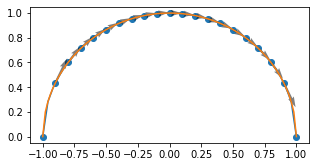

In [36]:
import jax
from jax import core
import numpy as np
from jax.interpreters import ad

import scipy
import functools
import matplotlib.pyplot as plt

def findroot(f):
    return scipy.optimize.brentq(f,a = 0,b = 10) 

def func(x,y):
    return x**2 + y**2 - 1

def y_for_x(x):
    return findroot(functools.partial(func,x))

xi = np.linspace(-1,1)
yi = np.asarray([y_for_x(xx) for xx in xi])

plt.plot(xi,yi)

findrootjax_p = core.Primitive('findrootjax')
findrootjax_p.def_impl(lambda x: y_for_x(x))
ad.defvjp(findrootjax_p, lambda g, x: - x / y_for_x(x))

def findrootjax(x):
    return findrootjax_p.bind(x)
jax.value_and_grad(findrootjax)(0.5)

xi = np.linspace(-1,1,101)
yi = [findrootjax(v) for v in xi]
plt.plot(xi,yi)



xi = np.linspace(-1,1,21)
vg = np.asarray([np.asarray(jax.value_and_grad(findrootjax)(v)) for v in xi])
plt.scatter(xi,vg[:,0])
plt.quiver(xi,vg[:,0],np.ones_like(vg[:,0]),vg[:,1],
    angles = 'uv',
    alpha = 0.5,
)
plt.gcf().set_size_inches(5,2.5)

## In HEP


Of course  we can use automatic differentiation
for neural networks. But other things in HEP also 
can make use of gradients. A prime example where this is the 
case is statistical analysis

For a maximum likelihood fit we want to minimize the log likelihood

$\theta^* = \mathrm{argmin}_\theta(\log L)$ 

In [37]:
import jax
import jax.numpy as jnp
import numpy as np
import pyhf
import matplotlib.pyplot as plt

In [38]:
pyhf.set_backend('jax')

In [39]:
m = pyhf.simplemodels.hepdata_like([5.],[30.],[25.])
pars = jnp.array(m.config.suggested_init())
data = jnp.array([35.] + m.config.auxdata)
m.logpdf(pars,data)

DeviceArray([-3.85729211], dtype=float64)

In [40]:
bestfit = pyhf.infer.mle.fit(data,m)
bestfit

DeviceArray([1., 1.], dtype=float64)

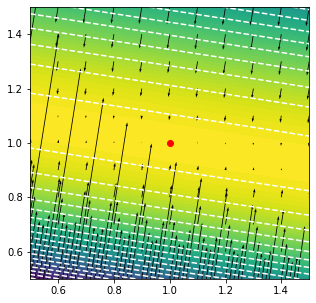

In [41]:
grid = x,y = np.mgrid[.5:1.5:101j,.5:1.5:101j]

points = np.swapaxes(grid,0,-1).reshape(-1,2)
v = jax.vmap(m.logpdf, in_axes = (0,None))(points,data)
v = np.swapaxes(v.reshape(101,101),0,-1)
plt.contourf(x,y,v, levels = 100)
plt.contour(x,y,v, levels = 20, colors = 'w')



grid = x,y = np.mgrid[0:2:21j,0:2:21j]
points = np.swapaxes(grid,0,-1).reshape(-1,2)
values, gradients = jax.vmap(
    jax.value_and_grad(
        lambda p,d: m.logpdf(p,d)[0]
    ), in_axes = (0,None)
)(points,data)

plt.quiver(
    x,
    y,
    np.swapaxes(gradients[:,0].reshape(21,21),0,-1),
    np.swapaxes(gradients[:,1].reshape(21,21),0,-1),
    angles = 'xy',
    units = 'xy',
    scale = 150
)
plt.scatter(bestfit[0],bestfit[1], c = 'r')

plt.xlim(0.5,1.5)
plt.ylim(0.5,1.5)
plt.gcf().set_size_inches(5,5)

## Thanks for joining the Tutorial!



<img src="./assets/schmidhuber.png" alt="A Matrix Vector Product" width="700"/>
